## k Nearest Neighbors and Model Evaluation

In this programming assignment you will use k Nearest Neighbors (kNN) to build a "model" that will estimate the compressive strength of various types of concrete. This assignment has several objectives:

1. Implement the kNN algorithm with k=9. Remember...the data + distance function is the model in kNN. In addition to asserts that unit test your code, you should "test drive" the model, showing output that a non-technical person could interpret.

2. You are going to compare the kNN model above against the baseline model described in the course notes (the mean of the training set's target variable). You should use 10 fold cross validation and Mean Squared Error (MSE):

$$MSE = \frac{1}{n}\sum^n_i (y_i - \hat{y}_i)^2$$

as the evaluation metric ("error"). Refer to the course notes for the format your output should take. Don't forget a discussion of the results.

3. use validation curves to tune a *hyperparameter* of the model. 
In this case, the hyperparameter is *k*, the number of neighbors. Don't forget a discussion of the results.

4. evaluate the *generalization error* of the new model.
Because you may have just created a new, better model, you need a sense of its generalization error, calculate that. Again, what would you like to see as output here? Refer to the course notes. Don't forget a discussion of the results. Did the new model do better than either model in Q2?

5. pick one of the "Choose Your Own Adventure" options.

Refer to the "course notes" for this module for most of this assignment.
Anytime you just need test/train split, use fold index 0 for the test set and the remainder as the training set.
Discuss any results.

## Load the Data

The function `parse_data` loads the data from the specified file and returns a List of Lists. The outer List is the data set and each element (List) is a specific observation. Each value of an observation is for a particular measurement. This is what we mean by "tidy" data.

The function also returns the *shuffled* data because the data might have been collected in a particular order that *might* bias training.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

In [2]:
def parse_data(file_name: str) -> List[List]:
    data = []
    file = open(file_name, "r")
    for line in file:
        datum = [float(value) for value in line.rstrip().split(",")]
        data.append(datum)
    random.shuffle(data)
    return data

In [3]:
data = parse_data("data/concrete_compressive_strength.csv")

In [4]:
data[0]

[393.0, 0.0, 0.0, 192.0, 0.0, 940.0, 758.0, 90.0, 48.79]

In [5]:
len(data)

1030

There are 1,030 observations and each observation has 8 measurements. The data dictionary for this data set tells us the definitions of the individual variables (columns/indices):

| Index | Variable | Definition |
|-------|----------|------------|
| 0     | cement   | kg in a cubic meter mixture |
| 1     | slag     | kg in a cubic meter mixture |
| 2     | ash      | kg in a cubic meter mixture |
| 3     | water    | kg in a cubic meter mixture |
| 4     | superplasticizer | kg in a cubic meter mixture |
| 5     | coarse aggregate | kg in a cubic meter mixture |
| 6     | fine aggregate | kg in a cubic meter mixture |
| 7     | age | days |
| 8     | concrete compressive strength | MPa |

The target ("y") variable is a Index 8, concrete compressive strength in (Mega?) [Pascals](https://en.wikipedia.org/wiki/Pascal_(unit)).

## Train/Test Splits - n folds

With n fold cross validation, we divide our data set into n subgroups called "folds" and then use those folds for training and testing. You pick n based on the size of your data set. If you have a small data set--100 observations--and you used n=10, each fold would only have 10 observations. That's probably too small. You want at least 30. At the other extreme, we generally don't use n > 10.

With 1,030 observations, n = 10 is fine so we will have 10 folds.
`create_folds` will take a list (xs) and split it into `n` equal folds with each fold containing one-tenth of the observations.

In [6]:
def create_folds(xs: List, n: int) -> List[List[List]]:
    k, m = divmod(len(xs), n)
    # be careful of generators...
    return list(xs[i * k + min(i, m) : (i + 1) * k + min(i + 1, m)] for i in range(n))

In [7]:
folds = create_folds(data, 10)

In [8]:
len(folds)

10

We always use one of the n folds as a test set (and, sometimes, one of the folds as a *pruning* set but not for kNN), and the remaining folds as a training set.
We need a function that'll take our n folds and return the train and test sets:

In [9]:
def create_train_test(
    folds: List[List[List]], index: int
) -> Tuple[List[List], List[List]]:
    training = []
    test = []
    for i, fold in enumerate(folds):
        if i == index:
            test = fold
        else:
            training = training + fold
    return training, test


We can test the function to give us a train and test datasets where the test set is the fold at index 0:

In [10]:
train, test = create_train_test(folds, 0)

In [11]:
len(train)

927

In [12]:
len(test)

103

## Q1: kNN

<a id="distance"></a>
### distance

`distance` prints the Euclidian distance between two data points. **Used by**: [knn](#knn)

* **example** List[float]: the list of feature values for a single datapoint
* **query** List[float]: the list of feature values for a single datapoint

**return**: float: the Euclidian distance between the two datapoints

In [13]:
def distance(example: List[float], query: List[float]) -> float:
    distance = 0
    for i, dimension in enumerate(example):
        distance += (dimension - query[i]) ** 2
    distance = np.sqrt(distance)
    return distance

In [14]:
d = distance([0, 0, 0], [1, 2, 2])
assert d == 3.0
d = distance([1, 2, 2], [2, 4, 4])
assert d == 3.0
d = distance([1, 2, 3], [2, 4, 5])
assert d == 3.0

<a id="y_average"></a>
### y_average

`y_average` averages the target variable. **Used by**: [knn](#knn)

* **data** List[Tuple[int,List]]: the list of knn and their feature values
* **target** int: the location of the target variable

**return**: float: the Euclidian distance between the two datapoints

In [15]:
def y_average(data: List[Tuple[int, List]], target: int):
    average = 0
    for i, value in enumerate(data):
        average += data[i][1][target]
    average = average / len(data)
    return average

In [16]:
a = y_average([(1.0, [2, 4, 6, 10]), (3.0, [1, 2, 3, 4])], 3)
assert a == 7
a = y_average([(1.0, [2, 4, 6, 10]), (3.0, [1, 2, 3, 4])], 2)
assert a == 4.5
a = y_average([(1.0, [2, 4, 6, 10]), (3.0, [1, 2, 3, 4])], 0)
assert a == 1.5

<a id="knn"></a>
### knn

`knn` determines which datapoints in a dataset are closest to the query point using Euclidian distance between features. Based on the closest points, and estimate of the target value is provided by averaging the target values of the closest points. **Uses**: [distance](#distance), [y_average](#y_average) **Used by**: [knn_performance](#knn_performance), [validation_curves](#validation_curves)

* **data** Tuple[List[List[float]]: the dataset to be compared to find the closest datapoints
* **query** List[float]: the list of feature values for a single datapoint
* **processing** Callable: the processing function to determine what value to return from the result of the kNN

**return**: Any: the result of the knn based on the processing function (default: float: average target value)

In [17]:
def knn(
    data: Tuple[List[List]], query: List[float], k: int, processing=y_average
) -> any:
    distances = []
    for example in data:
        distances.append((distance(example[: len(example) - 1], query), example))
    distances.sort()
    nearest = distances[:k]
    return processing(nearest, len(nearest[0][1]) - 1)


In [18]:
k = knn([[0, 0, 0], [1, 2, 2], [2, 4, 4]], [1, 4, 5], 1)
assert k == 4.0
k = knn([[1, 2, 3], [4, 5, 6], [7, 8, 9]], [11, 11, 12], 1)
assert k == 9.0
k = knn([[1, 2, 3, 4], [2, 4, 6, 10], [100, 200, 300, 400]], [2, 4, 5, 6], 2)
assert k == 7.0

**kNN Test**

The output of `knn` is the distance between a query point and a point in the dataset, followed by the feature values of the dataset datapoint the distance belongs to. The test below shows the 9 closest points in the train dataset to test point 0 sorted from closest to furthest away.

In [19]:
n = knn(train, test[5], 9)
print(
    f"From 9 of the nearest neighbors to "
    f"point {test[0]}: the resulting estimated target value is: "
    f"{n:0.2f} and the actaul target value is: {test[0][len(test[0])-1]}"
)

From 9 of the nearest neighbors to point [393.0, 0.0, 0.0, 192.0, 0.0, 940.0, 758.0, 90.0, 48.79]: the resulting estimated target value is: 42.29 and the actaul target value is: 48.79


## Q2: Evaluation vs. The Mean

<a id="mean_column"></a>
### mean_column

`mean_column` finds the mean value of a column in a list. **Used by**: [null_performance](#null_performance)

* **data** List[List]: the list of values to take the mean of
* **column** int: the column to take the mean of

**return**: float: the mean value from the list

In [20]:
def mean_column(data: List[List], column) -> float:
    mean = 0
    for i, value in enumerate(data):
        mean += data[i][column]
    mean = mean / len(data)
    return mean

In [21]:
m = mean_column([[1, 2], [2, 3], [3, 4]], 0)
assert m == 2.0
m = mean_column([[1, 2], [2, 3], [3, 4]], 1)
assert m == 3.0
m = mean_column([[1, 2, 0], [2, 3, 0], [3, 4, 0]], 2)
assert m == 0.0

<a id="mse"></a>
### mse

`mse` finds the mean squared error. **Used by**: [null_performance](#null_performance), [knn_performance](#knn_performance), [validation_curves](#validation_curves)

* **actual** List: the list of actaul target values
* **predicted** List: the list of predicted target values

**return**: float: the mean squared error

In [22]:
def mse(actual: List, predicted: List) -> float:
    mse = 0
    for i, value in enumerate(actual):
        mse += (actual[i] - predicted[i]) ** 2
    mse = mse / len(actual)
    return mse

In [23]:
e = mse([3, 4], [5, 7])
assert e == 6.5
e = mse([1, 1], [2, 2])
assert e == 1.0
e = mse([9], [11])
assert e == 4.0

<a id="extract_column"></a>
### extract_column

`extract_column` extracts a column into a list from a list of lists. **Used by**: [null_performance](#null_performance), [knn_performance](#knn_performance), [validation_curves](#validation_curves)

* **data** List[List]: the list of lists
* **column** int: determines which column to extract

**return**: List: the extracted column as a list

In [24]:
def extract_column(data: List[List], column) -> List:
    extract = []
    for i, value in enumerate(data):
        extract.append(data[i][column])
    return extract

In [25]:
d = extract_column([[1, 4, 7], [2, 5, 8], [3, 6, 9]], 0)
assert d == [1, 2, 3]
d = extract_column([[1, 4, 7], [2, 5, 8], [3, 6, 9]], 1)
assert d == [4, 5, 6]
d = extract_column([[1, 4, 7], [2, 5, 8], [3, 6, 9]], 2)
assert d == [7, 8, 9]

<a id="null_performance"></a>
### null_performance

`null_performance` runs the baseline performance of comparing the target values to the mean target value. **Uses**: [mean_column](#mean_column), [extract_column](#extract_column), [mse](#mse) 

* **folds** List[List]: the list of k-folds created

In [26]:
def null_performance(folds: List[List]):
    test_mse = []
    for i, fold in enumerate(folds):
        train, test = create_train_test(folds, i)

        target_mean = mean_column(train, len(train[0]) - 1)
        mean_list = [target_mean] * len(test)

        test_actual = extract_column(test, len(test[0]) - 1)
        test_mse.append(mse(test_actual, mean_list))

        print(f"Fold {i+1} mean squared error: {test_mse[i]:0.2f}")

    average = sum(test_mse) / len(test_mse)
    print(f"Average mean squared error: {average:0.2f}")

In [27]:
null_performance(folds)

Fold 1 mean squared error: 264.00
Fold 2 mean squared error: 310.85
Fold 3 mean squared error: 238.47
Fold 4 mean squared error: 327.70
Fold 5 mean squared error: 261.61
Fold 6 mean squared error: 297.39
Fold 7 mean squared error: 248.59
Fold 8 mean squared error: 267.34
Fold 9 mean squared error: 333.17
Fold 10 mean squared error: 246.04
Average mean squared error: 279.52


<a id="knn_performance"></a>
### knn_performance

`knn_performance` determines the performance of comparing the target values to the knn estimate of the target value by calculating the mean squared error over folds and k nearest neighbors. **Uses**: [extract_column](#extract_column), [mse](#mse), [knn](#knn) **Used by**: [learning_curves](#learning_curves)

* **folds** List[List]: the list of k-folds created
* **k** int: determines how many nearest neighbors to use
* **include_train** boolean: determines if training data should be knn estimated as well as test data

**return** List[float]: the average mse for test and train data

In [28]:
def knn_performance(folds, k, include_train) -> List[float]:
    test_mse = []
    train_mse = []
    for i_folds, fold in enumerate(folds):
        train, test = create_train_test(folds, i_folds)
        knn_estimate_train = []
        knn_estimate_test = []
        for i_test, test_point in enumerate(test):
            knn_estimate_test.append(knn(train, test_point, k))
        if include_train:
            for i_train, train_point in enumerate(train):
                knn_estimate_train.append(knn(train, train_point, k))
            train_actual = extract_column(train, len(train[0]) - 1)
            train_mse.append(mse(train_actual, knn_estimate_train))
        else:
            train_mse = [0]
        test_actual = extract_column(test, len(test[0]) - 1)
        test_mse.append(mse(test_actual, knn_estimate_test))
        print(f"Fold {i_folds+1} mean squared error: {test_mse[i_folds]:0.2f}")
    average_train = sum(train_mse) / len(train_mse)
    average_test = sum(test_mse) / len(test_mse)
    print(f"Average mean squared error: {average_test:0.2f}")
    return average_train, average_test

In [29]:
knn_nine = knn_performance(folds, 9, False)

Fold 1 mean squared error: 90.38
Fold 2 mean squared error: 105.53
Fold 3 mean squared error: 61.95


Fold 4 mean squared error: 65.01
Fold 5 mean squared error: 92.13
Fold 6 mean squared error: 111.63
Fold 7 mean squared error: 82.82
Fold 8 mean squared error: 75.84
Fold 9 mean squared error: 124.72
Fold 10 mean squared error: 73.12
Average mean squared error: 88.31


**Performance Discussion**

The kNN model outperforms the null model by a large margin. The average MSE over 10 folds for the null model is more than twice of the kNN model. This means that the kNN model does a better job of estimating values for concrete compressive strength based on the features provided than just going with the average strength.

## Q3: Hyperparameter Tuning

<a id="validation_curves"></a>
### validation_curves

`validation_curves` generates the mse for train and test data based on cycling through various k values. **Uses**: [extract_column](#extract_column), [mse](#mse), [knn](#knn)

* **folds** List[List]: the list of k-folds created
* **max_k** int: determines how maximum nearest neighbors to use
* **min_k** int: determines how minimum nearest neighbors to use

**return** List[List]: the mse for test and train data over k values

In [30]:
def validation_curves(fold, max_k, min_k):
    test_mse = []
    train_mse = []

    train, test = create_train_test(folds, 0)
    while max_k > min_k:
        knn_estimate_train = []
        knn_estimate_test = []
        for i_test, test_point in enumerate(test):
            knn_estimate_test.append(knn(train, test_point, max_k))
        for i_train, train_point in enumerate(train):
            knn_estimate_train.append(knn(train, train_point, max_k))

        train_actual = extract_column(train, len(train[0]) - 1)
        train_mse.insert(0, mse(train_actual, knn_estimate_train))

        test_actual = extract_column(test, len(test[0]) - 1)
        test_mse.insert(0, mse(test_actual, knn_estimate_test))
        max_k -= 1
    return train_mse, test_mse

In [31]:
graph = validation_curves(folds, 15, 0)

<function matplotlib.pyplot.show(close=None, block=None)>

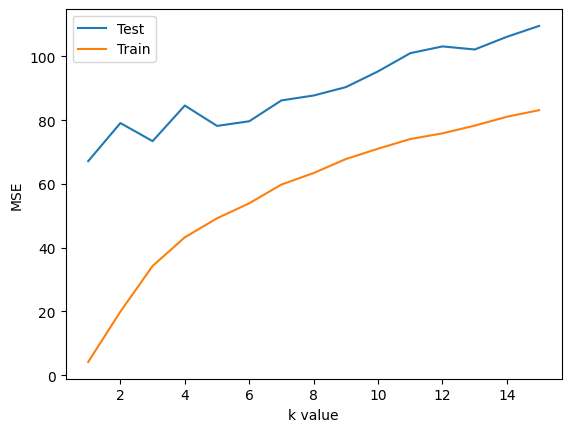

In [32]:
x = [i + 1 for i, x in enumerate(graph[0])]
plt.plot(x, graph[1], label="Test")
plt.plot(x, graph[0], label="Train")
plt.legend()
plt.xlabel("k value")
plt.ylabel("MSE")
plt.show

**Performance Discussion**

Depending on how the data is sliced the results from the validation curve can vary quite a bit. Overall, the best performance seems to be around k=2-6 for the test data. The training data error always increases with higher k since there are more values to average over. With k=1 the error is zero for the training data since knn can find istelf as the nearest neighbor. With k values over 6 the error increases for the test data as well since a larger population is being avaluated to find an average which could incorporate outliers to reach the required 5+ neighbors.

## Q4: Generalization Error

In [33]:
knn_five = knn_performance(folds, 5, False)

Fold 1 mean squared error: 78.22
Fold 2 mean squared error: 94.34
Fold 3 mean squared error: 53.27
Fold 4 mean squared error: 69.75
Fold 5 mean squared error: 80.62
Fold 6 mean squared error: 106.84
Fold 7 mean squared error: 76.92
Fold 8 mean squared error: 61.39
Fold 9 mean squared error: 109.50
Fold 10 mean squared error: 56.30
Average mean squared error: 78.72


In [34]:
print(
    f"The difference in performance between k=9 and k=5 is: {(knn_nine[1] - knn_five[1]):0.2f}"
)


The difference in performance between k=9 and k=5 is: 9.60


**Performance Discussion**

The results show that k=5 performed better than k=9 by a slight margin. This might change a bit depending on how the folds fall out but overall they should have similar performance until the k values get fairly large.

## Q5: Choose your own adventure

You have three options for the next part:

1. You can implement mean normalization (also called "z-score standardization") of the *features*; do not normalize the target, y. See if this improves the generalization error of your model (middle).

2. You can implement *learning curves* to see if more data would likely improve your model (easiest).

3. You can implement *weighted* kNN and use the real valued GA to choose the weights. weighted kNN assigns a weight to each item in the Euclidean distance calculation. For two points, j and k:
$$\sqrt{\sum w_i (x^k_i - x^j_i)^2}$$

You can think of normal Euclidean distance as the case where $w_i = 1$ for all features  (ambitious, but fun...you need to start EARLY because it takes a really long time to run).

The easier the adventure the more correct it must be...

<a id="learning_curves"></a>
### learning_curves

`learning_curves` generates the mse for train and test data based on cycling through various quantities of data. **Uses**: [knn_performance](#knn_performance)

* **data** data: Tuple[List[List]]: the list all the available data

**return** List[List]: the mse for test and train data

In [35]:
def learning_curves(data: Tuple[List[List]]):
    knn_curves = []
    percent = 0.1
    while percent <= 1:
        _data = data[: int(len(data) * percent)]
        folds = create_folds(_data, 10)
        knn_curves.append(knn_performance(folds, 5, True))
        print(f"MSE for percent data {percent:0.1f}")
        print()
        percent += 0.1
    return knn_curves

In [36]:
learning = learning_curves(data)

Fold 1 mean squared error: 124.34
Fold 2 mean squared error: 175.89
Fold 3 mean squared error: 282.40
Fold 4 mean squared error: 227.75
Fold 5 mean squared error: 213.08
Fold 6 mean squared error: 128.56
Fold 7 mean squared error: 111.30
Fold 8 mean squared error: 228.56
Fold 9 mean squared error: 136.08
Fold 10 mean squared error: 258.83
Average mean squared error: 188.68
MSE for percent data 0.1

Fold 1 mean squared error: 136.64
Fold 2 mean squared error: 202.26
Fold 3 mean squared error: 186.06
Fold 4 mean squared error: 105.96
Fold 5 mean squared error: 204.47
Fold 6 mean squared error: 151.55
Fold 7 mean squared error: 114.03
Fold 8 mean squared error: 115.03
Fold 9 mean squared error: 173.20
Fold 10 mean squared error: 209.93
Average mean squared error: 159.91
MSE for percent data 0.2

Fold 1 mean squared error: 133.56
Fold 2 mean squared error: 176.39
Fold 3 mean squared error: 92.30
Fold 4 mean squared error: 143.91
Fold 5 mean squared error: 115.97
Fold 6 mean squared error: 

<function matplotlib.pyplot.show(close=None, block=None)>

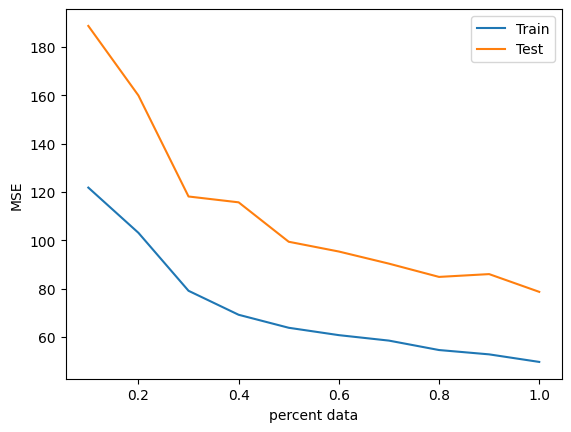

In [37]:
x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
plt.plot(x, learning, label=["Train", "Test"])
plt.legend()
plt.xlabel("percent data")
plt.ylabel("MSE")
plt.show

**Performance Discussion**

Based on the learning curves, more data would be helpful for this model since both curves are trending down to a lower MSE. There is still a wide gap between the train and test data so it is likely overfitting to the train data. Also, they haven't converged yet so it isn't in the underfitting case. 

One thing that still needs to be understood is what an acceptable error rate would be. If the model is already at an acceptable rate with the test data then more data isn't necessary. However, it seems like more data would help to model perform better.